In [11]:
from elasticsearch import Elasticsearch
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda
import pickle
import re
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Connect to ES & Query

In [2]:
es = Elasticsearch(['elasticsearch:9200'])

In [8]:
try:
    fluentdIndex = list(es.indices.get_alias("fluentd-*").keys())[0]
except:
    print("Please, run any container with Fluentd as the log driver first")

In [9]:
n = 10
body = {
  "query": {
    "match_all": {}
  },
  "size": n,
  "sort": [
    {
      "@timestamp": {
        "order": "desc"
      }
    }
  ]
}


response = es.search(index=fluentdIndex, body=body)

In [10]:
fields = {}
for num, doc in enumerate(response["hits"]["hits"]):
    source_data = doc["_source"]
    for key, val in source_data.items():
        try:
            fields[key] = np.append(fields[key], val)
        except KeyError:
            fields[key] = np.array([val])

In [11]:
elastic_df = pd.DataFrame(fields)
elastic_df.head()

,source,log,container_id,container_name,@timestamp,@log_name
0,stderr,ts=2020-10-08T20:47:33Z caller=logging.go:29 m...,5e263eb0aec4cecb6b198de0024522ec38ee6072ff5559...,/docker-compose_payment_1,2020-10-08T20:47:33.000000000+00:00,docker.5e263eb0aec4
1,stderr,ts=2020-10-08T20:47:33Z caller=logging.go:29 m...,5e263eb0aec4cecb6b198de0024522ec38ee6072ff5559...,/docker-compose_payment_1,2020-10-08T20:47:33.000000000+00:00,docker.5e263eb0aec4
2,stdout,Attempting to delete cart for user: 57a98d98e4...,b5478ce2f915113837c99c06bd494056f4f41f6cb195fa...,/docker-compose_front-end_1,2020-10-08T20:47:33.000000000+00:00,docker.b5478ce2f915
3,stdout,User cart deleted with status: 202,b5478ce2f915113837c99c06bd494056f4f41f6cb195fa...,/docker-compose_front-end_1,2020-10-08T20:47:33.000000000+00:00,docker.b5478ce2f915
4,stdout,[0mDELETE /cart [32m202 [0m6.382 ms - -[0m,b5478ce2f915113837c99c06bd494056f4f41f6cb195fa...,/docker-compose_front-end_1,2020-10-08T20:47:33.000000000+00:00,docker.b5478ce2f915


In [12]:
elastic_df.to_csv('elastic.csv', index=False)

In [2]:
elastic_df = pd.read_csv('elastic.csv')

## Data Cleaning

In [3]:
elastic_df = elastic_df.drop(columns=['container_id', '@log_name'])

In [4]:
elastic_df["processed_log"] = elastic_df['log'].map(lambda x: re.sub('[-=:/,\.!?]', ' ', str(x)))

In [5]:
elastic_df["processed_log"] = elastic_df["processed_log"].map(lambda x: x.lower())

In [6]:
elastic_df["processed_log"]

0    ts 2020 10 08t20 47 33z caller logging go 29 m...
1    ts 2020 10 08t20 47 33z caller logging go 29 m...
2    attempting to delete cart for user  57a98d98e4...
3                   user cart deleted with status  202
4       delete  cart 202 6 382 ms    
5    attempting to add to cart  {"id" "a0a4f044 b04...
6    attempting to delete cart for user  57a98d98e4...
7    {"id" "a0a4f044 b040 410d 8ead 4de0446aec7e" "...
8                                                  nan
9    post to carts  http   carts carts 57a98d98e4b0...
Name: processed_log, dtype: object

## EDA

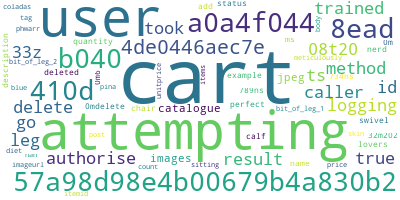

In [7]:
long_string = ','.join(list(elastic_df["processed_log"].values))

wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


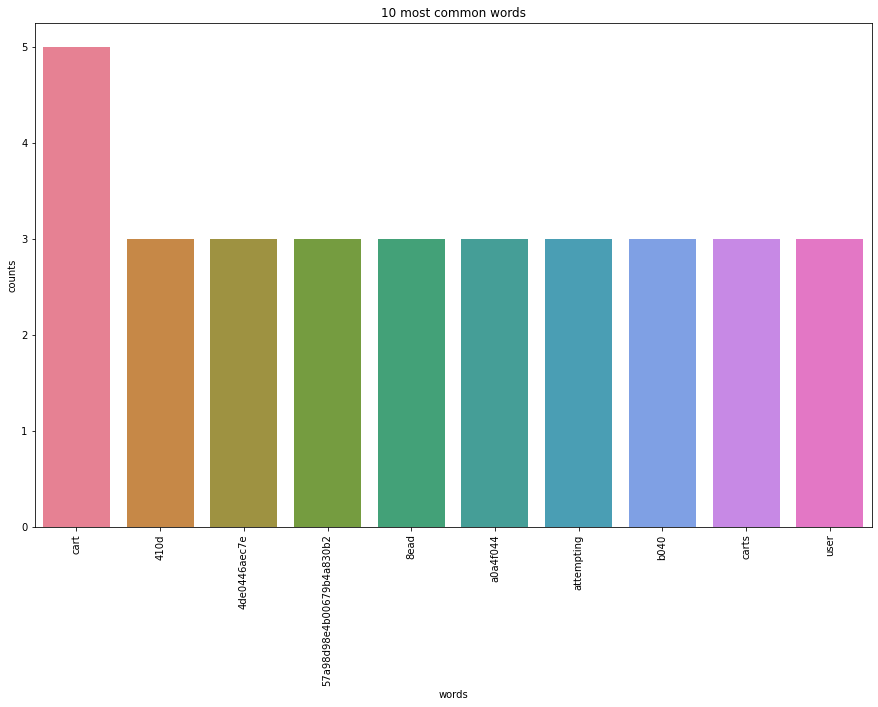

In [9]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(elastic_df["processed_log"])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

## LDA

In [10]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
carts 57a98d98e4b00679b4a830b2 attempting user delete cart 4de0446aec7e b040 8ead 410d

Topic #1:
08t20 29 logging result authorise caller 33z 47 2020 took

Topic #2:
cart ms 0m 0m6 0mdelete 32m202 382 202 status deleted

Topic #3:
jpeg trained catalogue images leg b040 410d 4de0446aec7e 8ead a0a4f044

Topic #4:
nan cart attempting user 410d 4de0446aec7e 8ead a0a4f044 b040 delete


In [13]:
log_vis_data = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [14]:
pyLDAvis.enable_notebook()
pyLDAvis.display(log_vis_data)

In [15]:
log_tsne = sklearn_lda.prepare(lda, count_data, count_vectorizer, mds='tsne')

In [16]:
pyLDAvis.display(log_tsne)